# Theoretical Modelling Analysis
This script will be used to generate plots for my thesis, in particular I'll generate each of the plots i need for the theoretical modelling analysis. This should be versatile enough to work for the ZFOURGE observational (semi-empirical) models, and the pure theoretical models.

In [123]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
# Choose if you want to save the plots
save_figures = False

In [125]:
# We would like to investigate the effects of the different filters.
# Read in the dataframe

template_set_name = 'Brown'
agn_model_name = 'Type1AGN'

composite_choice = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_name}'

# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_name}'
composite_fluxes = pd.read_csv(f'outputs\composite_seds\{composite_choice}.csv', index_col=0)   
# Drop the first col
composite_fluxes = composite_fluxes.drop(columns=['Unnamed: 0.1'])

In [126]:
# Check outputs
composite_fluxes

,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
0,Arp_118,0.0,-21.198908,-21.315776,-21.421279,-21.517432,-21.605757,-21.687435,-21.763396,-21.834388,...,-23.454779,-23.475153,-23.495151,-23.514788,-23.534076,-23.553028,-23.571654,-23.589966,-23.607974,-23.625689
1,Arp_256_N,0.0,-20.237172,-20.287567,-20.335726,-20.381839,-20.426074,-20.468576,-20.509478,-20.548894,...,-21.492481,-21.513877,-21.534859,-21.555444,-21.575645,-21.595478,-21.614955,-21.634088,-21.652890,-21.671372
2,Arp_256_S,0.0,-20.201401,-20.302567,-20.395105,-20.480372,-20.559427,-20.633115,-20.702117,-20.766996,...,-21.460665,-21.504041,-21.545751,-21.585917,-21.624651,-21.662050,-21.698203,-21.733192,-21.767088,-21.799958
3,CGCG_049-057,0.0,-17.401194,-17.657027,-17.863926,-18.037638,-18.187352,-18.318902,-18.436221,-18.542091,...,-19.901468,-19.939198,-19.975661,-20.010938,-20.045106,-20.078231,-20.110376,-20.141596,-20.171943,-20.201465
4,CGCG_436-030,0.0,-20.094718,-20.244207,-20.375583,-20.492764,-20.598521,-20.694885,-20.783389,-20.865219,...,-21.546386,-21.601016,-21.653028,-21.702663,-21.750127,-21.795603,-21.839250,-21.881211,-21.921609,-21.960559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,UGC_09618_N,3.9,37.371478,28.856104,28.103742,27.663585,27.351274,27.109020,26.911081,26.743724,...,27.953385,27.384060,27.012499,26.736186,26.516120,26.333229,26.176750,26.040009,25.918579,25.809374
5116,UGC_09618,3.9,36.333443,28.487211,27.735031,27.294934,26.982653,26.740418,26.542491,26.375143,...,27.182581,26.759907,26.456444,26.219535,26.025174,25.860380,25.717334,25.590959,25.477772,25.375279
5117,UGC_09618_S,3.9,34.982780,29.716301,28.967982,28.529176,28.217541,27.975693,27.778025,27.610862,...,27.645340,27.417662,27.229551,27.069268,26.929633,26.805926,26.694884,26.594152,26.501977,26.417019
5118,UGC_12150,3.9,38.434321,29.718392,28.965994,28.525825,28.213508,27.971250,27.773309,27.605950,...,29.110326,28.410883,27.988959,27.685882,27.449206,27.255002,27.090322,26.947361,26.821052,26.707918


In [127]:
# Check for each entry of a particular filter, how many variations of it there are i.e U_0, U_10
# Allow us to have a robust way of investigating the effects of the different alpha values automatically, without recoding the filter names/alpha values

# Get the filters
filters = composite_fluxes.columns[2:]

# For the first filter, see how many variations there are
filter_choice = filters[0].split('_')[0]


# Get the variations
filter_variations = [filter for filter in filters if filter_choice in filter]

# add the alpha values to a new array
alpha_values = [int(filter.split('_')[1]) for filter in filter_variations]

# Print the alpha values
print(alpha_values)


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


UVJ Diagrams

In [128]:

# Check the values


ugr Diagrams



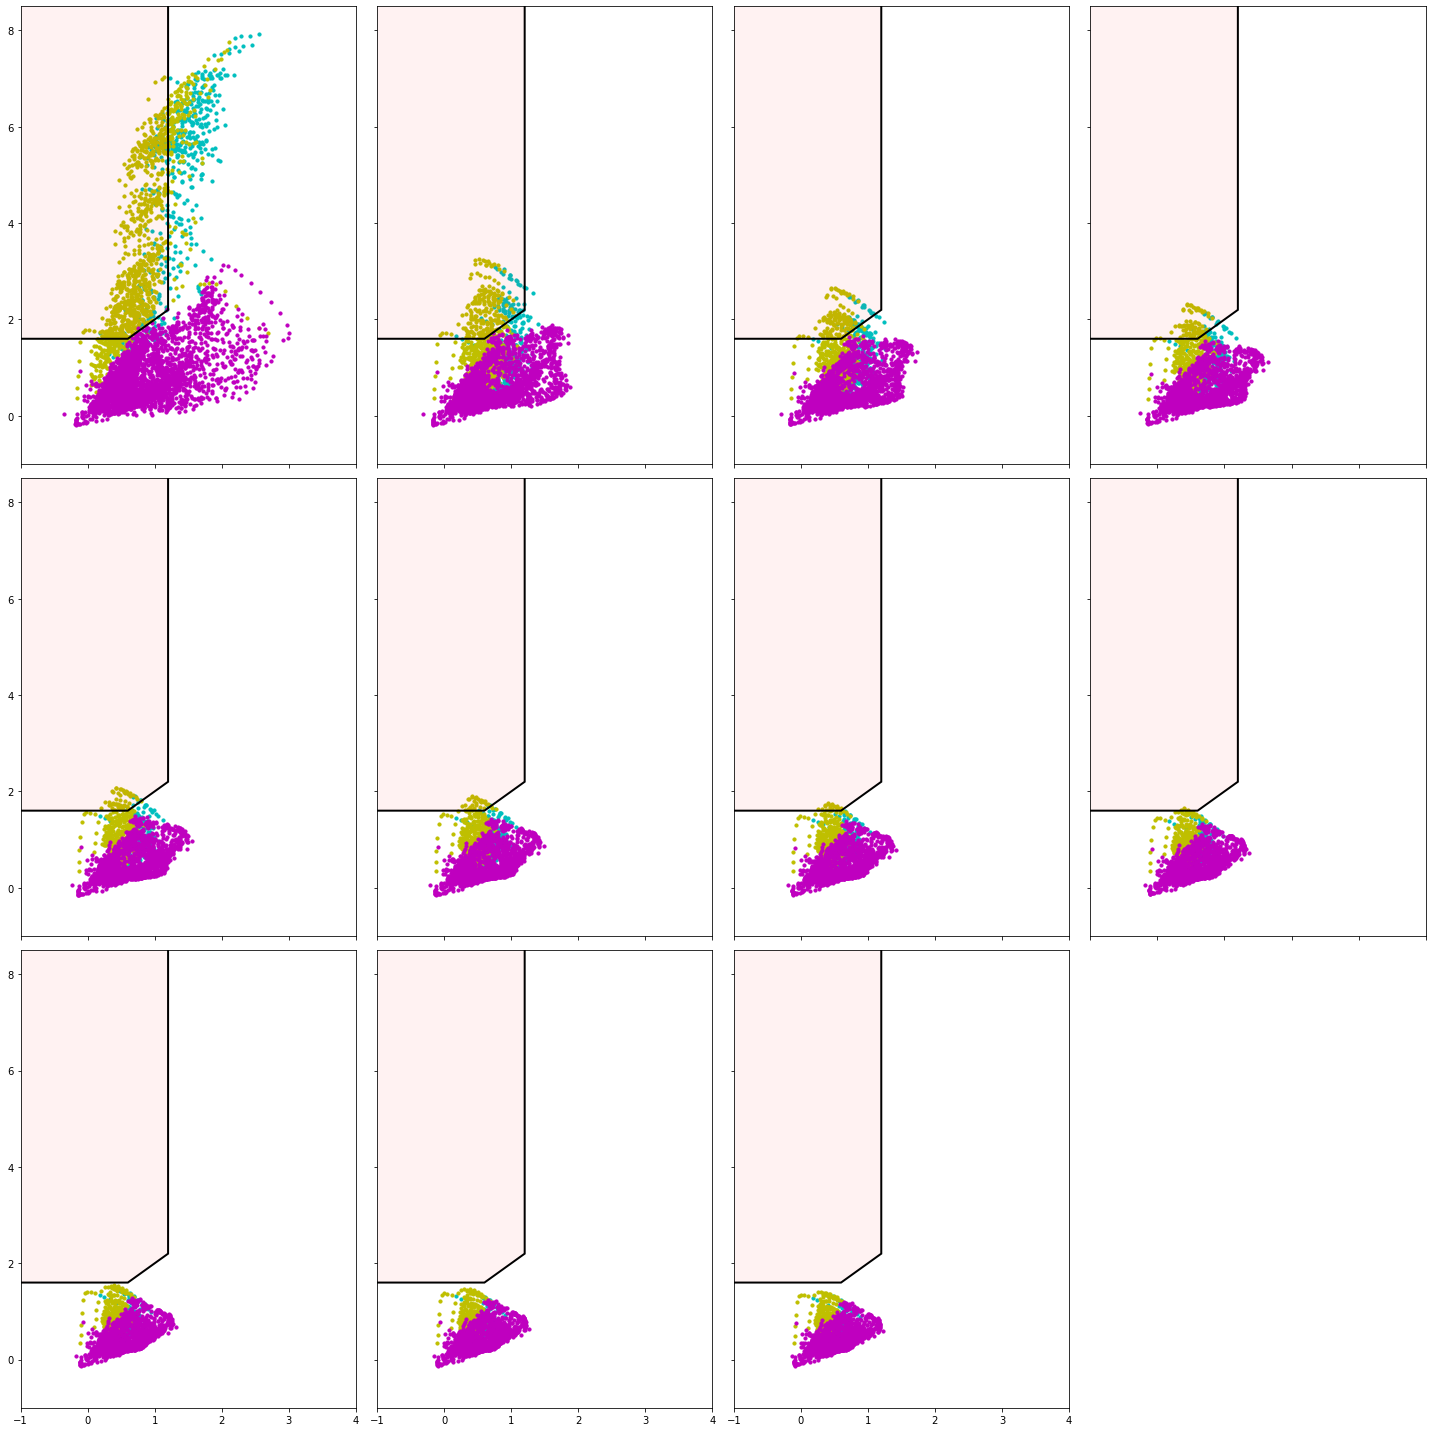

In [129]:
fig, axs = plt.subplots(3, 4, figsize=(20, 20), sharex=True, sharey=True)



for n in range(len(alpha_values)):
    # Get the ug and gr colors for the specific alpha value
    u_col_name = f'u_{int(round(alpha_values[n], 2))}'
    g_col_name = f'g_{int(round(alpha_values[n], 2))}'
    r_col_name = f'r_{int(round(alpha_values[n], 2))}'

    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]

    # Scatter plots with color-coded redshift ranges
    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               c="c", s=10, label="z > 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               c="y", s=10, label="2.6 < z < 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               c="m", s=10, label="z < 2.6")
    
    
    plt.xlabel("G-R")
    plt.ylabel("U-G")
    #plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

    
    
    # add the alpha value information onto the plot somewhere
    #axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

    # Additionally we can plot the UGR selection criteria on the UGR diagram
    U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
    axs[n//4, n%4].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

    axs[n//4, n%4].set_xlim(-1, 4)
    axs[n//4, n%4].set_ylim(-1, 8.5)
    
    # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr
# Remove final plot
fig.delaxes(axs[2, 3])

# # Make all the plots touch
# plt.subplots_adjust(wspace=-0.5, hspace=0)

plt.tight_layout()    

if save_figures:
    plt.savefig(f'outputs/UGRPlots/ugr_alpha_{agn_model_name}.png')
    
# Plot
plt.show()
    

In [130]:
# Checkout the colours for the 'z' < 2.5

# check 
composite_fluxes[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] < 3.5)]

,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
3456,Arp_118,2.7,28.690801,27.002055,26.370594,25.973938,25.684050,25.455478,25.266756,25.106032,...,25.727877,25.410474,25.165177,24.965213,24.796413,24.650359,24.521643,24.406582,24.302555,24.207629
3457,Arp_256_N,2.7,27.918186,27.619833,27.386041,27.193780,27.030498,26.888591,26.763107,26.650634,...,25.854156,25.784998,25.719982,25.658641,25.600580,25.545468,25.493018,25.442986,25.395158,25.349349
3458,Arp_256_S,2.7,28.339225,27.627044,27.200621,26.895243,26.657171,26.462029,26.296675,26.153207,...,25.962969,25.816337,25.687173,25.571754,25.467434,25.372265,25.284769,25.203802,25.128456,25.058001
3459,CGCG_049-057,2.7,33.885079,30.101224,29.365418,28.930837,28.621325,28.380755,28.183939,28.017386,...,29.657229,28.962428,28.542162,28.239935,28.003778,27.809923,27.645492,27.502720,27.376559,27.263543
3460,CGCG_436-030,2.7,29.480718,27.815844,27.187235,26.791687,26.502390,26.274183,26.085710,25.925167,...,26.213224,25.971449,25.773830,25.606701,25.461900,25.334158,25.219875,25.116485,25.022089,24.935248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,UGC_09618_N,3.4,36.397379,28.502541,27.750344,27.310241,26.997957,26.755720,26.557792,26.390443,...,27.538763,27.015975,26.664589,26.399547,26.186677,26.008779,25.855968,25.722034,25.602822,25.495414
4476,UGC_09618,3.4,35.233985,28.133197,27.381407,26.941440,26.629224,26.387028,26.189127,26.021797,...,26.692568,26.328517,26.056362,25.838936,25.657871,25.502729,25.367010,25.246386,25.137833,25.039154
4477,UGC_09618_S,3.4,33.967311,29.355952,28.611170,28.173553,27.862513,27.621023,27.423594,27.256601,...,27.176655,26.979470,26.812652,26.668084,26.540523,26.426386,26.323114,26.228818,26.142060,26.061725
4478,UGC_12150,3.4,37.700140,29.364993,28.612670,28.172526,27.860221,27.617971,27.420034,27.252679,...,28.776756,28.094600,27.678898,27.379025,27.144303,26.951416,26.787681,26.645434,26.519682,26.406995


IRAC Diagrams
